# Frozen Lake env with Random starting and End Points, trained on RlLib

![Frozen Lake](frozenLake_testing.gif)


In [1]:
import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.dqn import DQNTrainer

import pygame
import numpy as np

import torch
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import time

from typing import List, Optional
from gym.envs.toy_text.frozen_lake import generate_random_map

from newGenerate_random_map import newGenerate_random_map

pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class WrappedFrozenLake(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.desc = self.env.desc
        self.size = len(self.desc)
        self.old = np.where((env.desc==b'S').reshape(self.size**2,))[0]
        self.goal = np.where((env.desc==b'G').reshape(self.size**2,))[0]
        self.observation_space = gym.spaces.Box(-0.1,1.1,shape=(3,self.size,self.size,),dtype="float32")
        self.action_space = self.env.action_space
        self.state_ = None
        
    def oneHot(self,s):
        x = np.zeros(self.size*self.size)
        x[s] = 1
        state_ = np.array([ x.reshape(self.size,self.size),
                         np.array(self.env.desc == b"F").astype("float32"),
                         np.array(self.env.desc == b"G").astype("float32")
                          ])
        return state_.reshape(3,self.size,self.size,) + (0.1*np.random.rand(3,self.size,self.size,)-0.05)

    def reset(self):
        # return self.oneHot(1)
        self.s = self.old
        self.state_ = self.oneHot(self.env.reset())
        return self.state_
    
    def step(self, action):
        obs, r, done, info = self.env.step(action)
        
        if obs == self.goal:
            done = True
            
        if done:
            reward = 2 if r > 0 else -1
        elif obs == self.old:
            reward = -1
        else:
            reward = 0
        self.old = obs
        self.state_ = self.oneHot(obs)
        return self.state_, reward, done, info
    
    def render(self, mode="rgb_array"):
        sqSize = 20
        canvasSize = sqSize*self.size+1
        canvas = pygame.Surface((canvasSize, canvasSize))
        canvas.fill((255, 255, 255))
        for i in range(self.size+2):
            pygame.draw.line(canvas, 0, (0, sqSize*i), (canvasSize, sqSize*i), width=1)
            pygame.draw.line(canvas, 0, ( sqSize*i,0), (sqSize*i,canvasSize, ), width=1)
        for i in range(self.size):
            for j in range(self.size):
                if (self.env.desc==b"H")[i,j]: # if there is a hole at ij
                    blackColor = (0,0,0)
                    pygame.draw.rect(canvas, blackColor, pygame.Rect(sqSize*(i)+1, sqSize*(j)+1, sqSize-1, sqSize-1))
                if (self.env.desc==b"G")[i,j]: # if there is a gole at ij
                    greenColor = (0,255,0)
                    pygame.draw.rect(canvas, greenColor, pygame.Rect(sqSize*(i), sqSize*(j), sqSize, sqSize))
                if self.state_[0,i,j] > 0.5:
                    blueColor = (0,0,255)
                    pygame.draw.circle(canvas, blueColor, (sqSize*i+sqSize/2,sqSize*j+sqSize/2) , sqSize/3)
        
        plArray = np.array(pygame.surfarray.pixels3d(canvas))
        plt.imshow(plArray)        
        plt.axis("off")

from ray.tune.registry import register_env

def env_creator(env_config): 
    size = env_config['size']
    numHoles = env_config['numHoles']
    p = 1-numHoles/(size**2)
    desc = newGenerate_random_map(size=size, p=p)
    return WrappedFrozenLake(gym.make('FrozenLake-v1', desc = desc, is_slippery=False))  # return an env instance

register_env("myenv", env_creator)

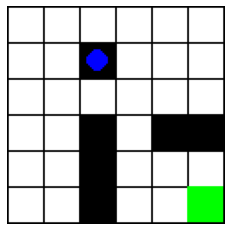

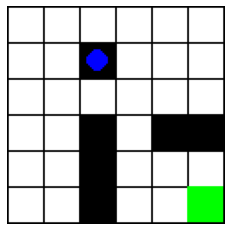

In [3]:
env = env_creator(env_config = {'size':6, 'numHoles': 10})
env.reset()
done = False

while not done:
    plt.cla()
    display.clear_output(wait=True)

    obs, reward, done, info = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.1)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf()
    

In [4]:
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.framework import try_import_tf, try_import_torch

torch, nn = try_import_torch()

class MyTorchModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs,
                              model_config, name)
        nn.Module.__init__(self)
        self.device = torch.device("cpu")#"cuda"
        #                            if torch.cuda.is_available() else "cpu")

        self.mainLayer = nn.Sequential(
                nn.Conv2d(3,12,kernel_size=3,stride= 1,padding=1),
                nn.ReLU(),
                nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
                nn.ReLU(),
                nn.Conv2d(24,36,kernel_size=3,stride=1,padding=1),
                nn.ReLU(),            
                nn.Flatten(start_dim=-3,end_dim=-1),
                nn.Linear(1296,256),
                nn.ReLU(),
                nn.Linear(256,256),
                nn.ReLU(),
        ).to(self.device)
        
        # Action logits output.
        self.layer_out = nn.Linear(256, num_outputs).to(self.device)

        # "Value"-branch (single node output).
        # Used by several RLlib algorithms (e.g. PPO) to calculate an observation's value.
        self.value_branch = nn.Linear(256, 1).to(self.device)
        self.cur_value = None

    def forward(self, input_dict, state, seq_lens):
        """Custom-define your forard pass logic here."""
        # Pass inputs through our 2 layers.
        layer_1_out = self.mainLayer(input_dict["obs"])
        logits = self.layer_out(layer_1_out)

        # Calculate the "value" of the observation and store it for
        # when `value_function` is called.
        self.cur_value = self.value_branch(layer_1_out).squeeze(-1)

        return logits, state

    def value_function(self):
        """Implement the value branch forward pass logic here:
        
        We will just return the already calculated `self.cur_value`.
        """
        assert self.cur_value is not None, "Must call `forward()` first!"
        return self.cur_value

In [5]:
size = 6
test_model_torch = MyTorchModel(
   obs_space=gym.spaces.Box(0,1,shape=(3,size,size), dtype=np.float32),
   action_space=gym.spaces.Discrete(4),
   num_outputs=4,
   model_config={},
   name="MyModel",
)
#print("Torch-output={}".format(test_model_torch({"obs": torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32))})))

obs = gym.spaces.Box(-0.1,1.1,shape=(3,size,size)).sample()
test_model_torch({"obs": torch.from_numpy(obs)})

(tensor([-0.0542,  0.0447, -0.0216, -0.0007], grad_fn=<AddBackward0>), [])

In [6]:
config = {
        "framework": "torch",
        "env":"myenv",  
        "env_config":{'size':6, 'numHoles': 10},
        "num_workers": 10,
          "model": {
             "custom_model": MyTorchModel,  # for torch users: "custom_model": MyTorchModel
             "custom_model_config": {},
          },
        'num_envs_per_worker': 200,
        "create_env_on_driver": True,
}

In [7]:
from ray import tune
tune_config = config.copy()
tune_config["lr"] = tune.grid_search([0.0001])  # <- 0.5? again: ouch!

stop = {
    "training_iteration": 50,
    "episode_reward_mean": 1.90,
}

analysis =  tune.run(
    "PPO",
    config=tune_config,
    stop=stop,
    checkpoint_at_end=True,  
    checkpoint_freq=5,  
    local_dir="checkPoints/",
    verbose=1,
    #resume=True
)

2022-07-25 10:52:58,519	INFO tune.py:747 -- Total run time: 674.41 seconds (673.46 seconds for the tuning loop).


In [9]:
# The previous tune.run (the one we did before the exercise) returned an Analysis object, from which we can access any checkpoint
# (given we set checkpoint_freq or checkpoint_at_end to reasonable values) like so:
print(analysis)
# Get all trials (we only have one).
trials = analysis.trials
# Assuming, the first trial was the best, we'd like to extract this trial's best checkpoint "":
best_checkpoint = analysis.get_best_checkpoint(trial=trials[0], metric="episode_reward_mean", mode="max")
print(f"Found best checkpoint for trial #2: {best_checkpoint}")


Found best checkpoint for trial #2: /home/ajit/Desktop/myRLcases/frozenLake-rlLib/checkPoints/PPO/PPO_myenv_46839_00000_0_lr=0.0001_2022-07-25_10-41-44/checkpoint_000050/checkpoint-50


In [ ]:
rllib_config = tune_config.copy()
rllib_config["lr"] = 0.0001
#rllib_config["train_batch_size"] = 4159
rllib_config["explore"] = False

# Restore a RLlib Trainer from the checkpoint.
new_trainer = PPOTrainer(config=rllib_config)
new_trainer.restore(best_checkpoint)

In [ ]:
new_trainer.evaluate()

In [12]:
won = 0
lost = 0
rewardList = []

for i in range(10):
    env = env_creator({'size':6, 'numHoles': 10}) #gym.make("myenv-v1")#"FrozenLake-v1")
    #, #FrozenLakeWrapped({})
    # Get the initial observation (should be: [0.0] for the starting position).
    obs = env.reset()
    done = False
    total_reward = 0.0
    # Play one episode.
    while not done:
        # plt.cla()
#        display.clear_output(wait=True)
        # print("num won: ", won, " played: ", i, "total reward: ", total_reward)
        # env.render()

        action = new_trainer.compute_single_action(obs,explore=False)
        obs, reward, done, info = env.step(action)
        #print(obs, reward, done)
        total_reward += reward
        # time.sleep(0.1)
        
        # display.display(plt.gcf())
        # plt.gcf()
        if done: 
            rewardList.append(total_reward)
    if reward > 0 :
        won +=1 
      
    
#print(rewardList, np.mean(rewardList))
print( np.mean(rewardList))

-78.0


In [13]:
won

1

In [ ]:
numPlay = 20
won = 0
for i in range(numPlay):
    env = env_creator({'size':6, 'numHoles': 10})# gym.make("FrozenLake-v1")
    obs = env.reset()
    done = False
    total_reward = 0.0
    # Play one episode.
    while not done:
        print("Played: ", i, ", won: ",won)

        plt.cla()
#        display.clear_output(wait=True)
        obs, reward, done, info = env.step(new_trainer.compute_single_action(obs,explore=False))
        if done and reward > 0:
            won += 1
        env.render()

        time.sleep(0.1)
        display.clear_output(wait=True)
        display.display(plt.gcf())
#        plt.gcf()
print("Played: ", numPlay, ", won: ",won)

In [28]:
won

11